# Skip-gram Word2Vec

In this notebook, I'll lead you through using PyTorch to implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.

---
## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

<img src='assets/lookup_matrix.png' width=50%>

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

<img src="assets/context_drink.png" width=40%>

Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.


There are two architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

<img src="assets/word2vec_architectures.png" width=60%>

In this implementation, we'll be using the **skip-gram architecture** with **negative sampling** because it performs better than CBOW and trains faster with negative sampling. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

---
## Loading Data

Next, we'll ask you to load in data and place it in the `data` directory

1. Load the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 
2. Place that data in the `data` folder in the home directory.
3. Then you can extract it and delete the archive, zip file to save storage space.

After following these steps, you should have one file in your data directory: `data/text8`.

In [1]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Pre-processing

Here I'm fixing up the text to make training easier. This comes from the `utils.py` file. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. 
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

This may take a few seconds to run, since our text file is quite large. If you want to write your own functions for this stuff, go for it!

In [2]:
import utils

# get list of words
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [3]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


### Dictionaries

Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). This is again done with a function in the `utils.py` file. `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [4]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

> Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [5]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[5233, 3133, 741, 10571, 27349, 15067, 58112, 3580, 10712, 214, 1324, 3672, 53, 1423, 2757, 7088, 1052, 27, 320, 248, 44611, 5233, 200, 8983, 4147, 6437, 4186, 5233, 6, 4860]


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [6]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [7]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]


### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [10]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 1, 2]


---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

<img src="assets/two_vectors.png" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [11]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

---
# SkipGram model

Define and train the SkipGram model. 
> You'll need to define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

Below is an approximate diagram of the general structure of our network.
<img src="assets/skip_gram_arch.png" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

---
## Negative Sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct example, but only a small number of incorrect, or noise, examples. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). 

There are two modifications we need to make. First, since we're not taking the softmax output over all the words, we're really only concerned with one output word at a time. Similar to how we use an embedding table to map the input word to the hidden layer, we can now use another embedding table to map the hidden layer to the output word. Now we have two embedding layers, one for input words and one for output words. Secondly, we use a modified loss function where we only care about the true example and a small subset of noise examples.

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

This is a little complicated so I'll go through it bit by bit. $u_{w_O}\hspace{0.001em}^\top$ is the embedding vector for our "output" target word (transposed, that's the $^\top$ symbol) and $v_{w_I}$ is the embedding vector for the "input" word. Then the first term 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

says we take the log-sigmoid of the inner product of the output word vector and the input word vector. Now the second term, let's first look at 

$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

This means we're going to take a sum over words $w_i$ drawn from a noise distribution $w_i \sim P_n(w)$. The noise distribution is basically our vocabulary of words that aren't in the context of our input word. In effect, we can randomly sample words from our vocabulary to get these words. $P_n(w)$ is an arbitrary probability distribution though, which means we get to decide how to weight the words that we're sampling. This could be a uniform distribution, where we sample all words with equal probability. Or it could be according to the frequency that each word shows up in our text corpus, the unigram distribution $U(w)$. The authors found the best distribution to be $U(w)^{3/4}$, empirically. 

Finally, in 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

we take the log-sigmoid of the negated inner product of a noise vector with the input vector. 

<img src="assets/neg_sampling_loss.png" width=50%>

To give you an intuition for what we're doing here, remember that the sigmoid function returns a probability between 0 and 1. The first term in the loss pushes the probability that our network will predict the correct word $w_O$ towards 1. In the second term, since we are negating the sigmoid input, we're pushing the probabilities of the noise words towards 0.

# why do not minimize this:  
$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} +
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$




# the original is :  
$$
Maximize
 \left[ \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} +
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)} \right]
$$

$$
\max \log{\sigma\left(-u\hspace{0.001em}^\top v\right)} = \max \log \frac{1}{1 + \exp^{uv}}  \equiv
\max \log \frac{1}{1 + \exp^{uv}}  \equiv \min \exp^{uv} \equiv \min uv
$$


Notice there is no other model parameters except for embedding matrices. Both input and output embeddings are trained. But here only the input embeddings are used for inferences and evaluation. I have seen both input and output embeddings can be summed up or averaged. The key is that both embedding matrixes are differentiable, and you take derivative of loss with respect to one, then you take derevative of loss with respoect to the other one. So within one iteration of loss.backward you are essentially updating ALLLLLL the parameters !  

In [12]:
import torch
from torch import nn
import torch.optim as optim

In [19]:


class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize both embedding tables with uniform distribution
        torch.manual_seed(3)
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        # return input vector embeddings
        x = self.in_embed(input_words)

        return x
    
    def forward_output(self, output_words):
        # return output vector embeddings
        x = self.out_embed(output_words)

        return x
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        # noise_dist: the input tensor containing probabilities
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)

        ## TODO: get the noise embeddings
        random_negative_out_embeddings = self.out_embed(noise_words)
        # reshape the embeddings so that they have dims (batch_size, n_samples, n_embed)
        random_negative_out_embeddings = random_negative_out_embeddings.view(batch_size, n_samples, -1)
        
        return random_negative_out_embeddings

In [20]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        # the two inputs of the function below: batch_size, n_samples
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/5
Loss:  6.660976409912109
often | simpsons, absinthe, weekends, workload, efficient
may | is, jimmy, exarchate, bill, te
during | hab, of, nine, reelection, january
has | accomplish, writer, sick, a, also
as | ministers, convicts, visible, nasa, air
all | bison, launch, madrid, restoration, jamaican
time | pierre, buckhead, three, of, shocks
with | of, the, africa, prayer, paint
pressure | wish, kid, front, styles, sativa
additional | confine, advanced, disposed, zodiac, harboring
institute | hiatus, citing, romanization, rey, art
pope | theoretically, ana, most, permit, murray
heavy | chileans, impeached, militia, sanderson, mercedes
orthodox | dyslexic, captain, resource, aau, enumerated
marriage | definition, abnormal, of, boron, sunday
event | wetlands, offerings, lowry, printed, pope
...

Epoch: 1/5
Loss:  5.151101589202881
only | is, with, a, as, in
s | the, in, one, and, a
two | one, to, the, and, six
while | in, cemetery, encouragement, pre, collection
also | a, the, 

Epoch: 3/5
Loss:  2.2968037128448486
state | states, government, representatives, elected, members
up | to, at, when, off, ground
nine | one, seven, zero, two, three
so | that, you, if, be, would
used | use, are, compounds, pure, generally
seven | one, nine, six, zero, two
who | he, wife, his, had, whom
he | his, him, himself, father, son
recorded | songs, albums, song, recordings, singles
derived | origin, names, derives, particularly, term
bible | testament, scriptures, biblical, christianity, jesus
magazine | weekly, magazines, illustrated, guide, www
defense | military, forces, defensive, deployed, missiles
woman | her, she, female, husband, sex
mainly | large, these, region, much, other
nobel | prize, laureate, physiology, writer, recipient
...

Epoch: 3/5
Loss:  2.3458356857299805
known | and, in, most, based, as
their | to, they, while, but, and
was | he, in, his, and, after
these | are, can, or, be, it
not | if, are, only, is, because
when | the, will, would, possible, they
cal

Epoch: 5/5
Loss:  2.268004894256592
all | would, so, no, they, not
while | to, more, would, for, have
seven | one, four, three, nine, eight
states | united, state, the, of, countries
known | the, from, by, as, and
over | in, and, the, years, its
they | that, their, some, but, these
were | was, from, to, and, remained
active | formed, capable, higher, replaced, switch
dr | keith, university, patrick, ralph, john
numerous | several, are, most, many, and
lived | died, whom, found, who, he
arts | martial, practitioners, theatre, training, schools
event | once, scavullo, opponents, hours, olympics
governor | governors, appointed, senators, lieutenant, representatives
ocean | atlantic, islands, volcanic, coast, volcanoes
...

Epoch: 5/5
Loss:  2.3334579467773438
such | or, these, are, as, commonly
there | are, for, is, as, any
th | century, nd, rd, st, one
world | america, most, major, history, american
been | the, have, evidence, has, still
known | has, is, as, in, a
system | systems, opera

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [23]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [24]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

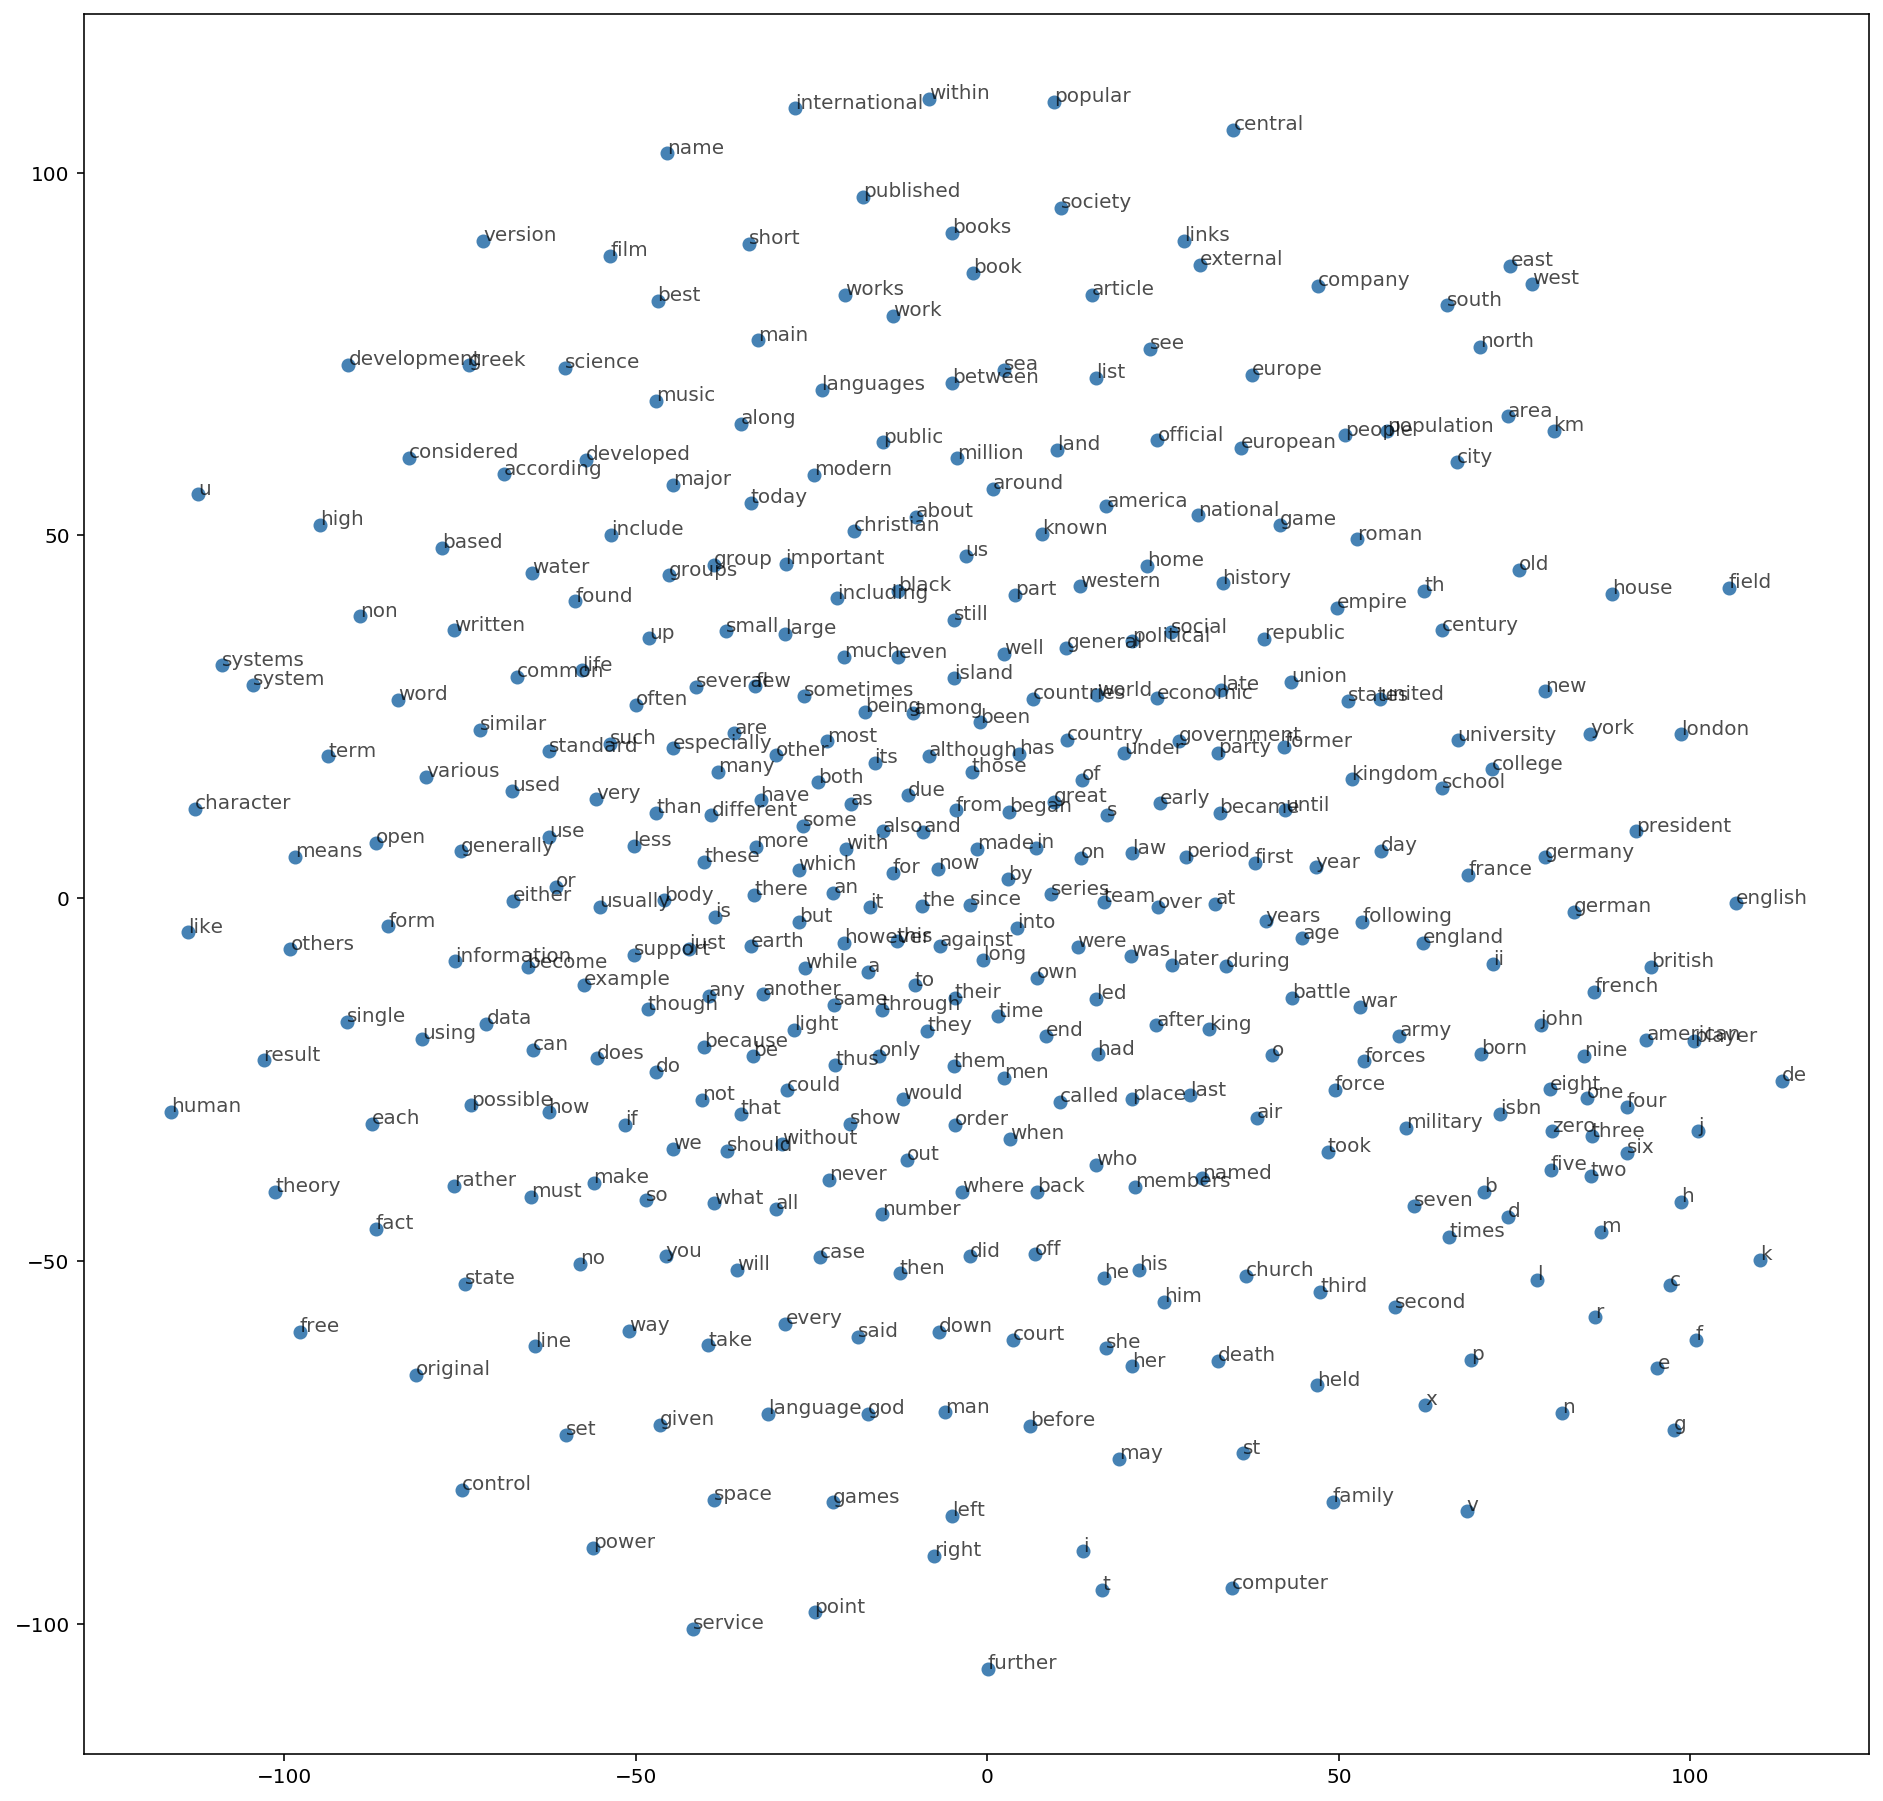

In [25]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)